### Load our dataset

In [43]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

[[0.24006667 0.17642745 0.1883451  ... 0.53740392 0.51157255 0.50502745]
 [0.07374118 0.         0.03952157 ... 0.37138431 0.35294902 0.36880392]
 [0.09394902 0.03487451 0.12318431 ... 0.35407843 0.35642353 0.31462745]
 ...
 [0.67814118 0.60308235 0.61440392 ... 0.52506275 0.14015294 0.14935294]
 [0.57394902 0.50476863 0.56298824 ... 0.59846275 0.27165882 0.23452549]
 [0.59088235 0.53596471 0.57565882 ... 0.73941961 0.48623922 0.38819216]]


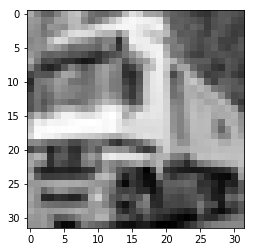

In [52]:
#gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

plt.imshow(x_train_gray[1], cmap='gray')

x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

## Prepare our labels

Here I use i to always save a different log on project update

In [46]:
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

i=0

In [49]:
from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

i=i+1

K.clear_session()

a = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_acc', filepath='../models/course6-cifar10-'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./mnist-conv-logs/cifar10-'+str(i))#saves a log file for tensorboard; remember to save different runs to different subdirectories
callbacks=[a,b,c]

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [66]:
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.optimizers import SGD
import keras
from keras.models import Model

i=i+1

a = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_acc', filepath='../models/course6-cifar10-inception-'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./mnist-conv-logs/cifar10-inception-'+str(i))#saves a log file for tensorboard; remember to save different runs to different subdirectories
callbacks=[a,b,c]

K.clear_session()

epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

input_img = Input(shape = (32, 32, 3))

tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)

output_pooled = MaxPooling2D((2,2), padding='same')(output)

tower_1_2 = Conv2D(384, (1,1), padding='same', activation='relu')(output_pooled)
tower_1_2 = Conv2D(384, (3,3), padding='same', activation='relu')(tower_1_2)

tower_2_2 = Conv2D(384, (1,1), padding='same', activation='relu')(output_pooled)
tower_2_2 = Conv2D(384, (5,5), padding='same', activation='relu')(tower_2_2)

tower_3_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(output_pooled)
tower_3_2 = Conv2D(384, (1,1), padding='same', activation='relu')(tower_3_2)

output_2 = keras.layers.concatenate([tower_1_2, tower_2_2, tower_3_2], axis = 3)

output = Flatten()(output_2)

dense = Dense(128)(output)

drop = Dropout(0.5)(dense)

out    = Dense(10, activation='softmax')(drop)

model = Model(inputs = input_img, outputs = out)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

Model type | Test accuracy
  ------------- | -------------
  c2, c2, mp, c2,c2,mp,f,d,d  | -
  c2, ap, c2, ap, c2, ap, f, d, d, do | 64.28 %, 60.22 %
  data-normalized, c2, ap, c2, ap, c2, ap, f, d, d, do | 65.83 %
  data-normalized-gray, c2, ap, c2, ap, c2, ap, f, d, d, do |  62.91 %
  inception-module | 62.82 % (stopped becuase of overfitting)
  inception dense drop | 62.89 %
  inception inception drop | 74.18 %
  inceptionx3 dense drop | 77.61 %
  inceptionx3 dense drop dense drop dense | 77.25 %

In [67]:
model.fit(x_train, y_train_cat, batch_size=128, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate(x_test, y_test_cat)

print("Accuracy on test set: ",result[1]*100,"%")

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 104s 3ms/step - loss: 1.6390 - acc: 0.4133 - val_loss: 1.2781 - val_acc: 0.5509

Epoch 00001: val_acc improved from -inf to 0.55090, saving model to ../models/course6-cifar10-inception-7.hdf5
Epoch 2/100
40000/40000 [==============================] - 101s 3ms/step - loss: 1.1944 - acc: 0.5788 - val_loss: 1.0617 - val_acc: 0.6297

Epoch 00002: val_acc improved from 0.55090 to 0.62970, saving model to ../models/course6-cifar10-inception-7.hdf5
Epoch 3/100
40000/40000 [==============================] - 101s 3ms/step - loss: 1.0127 - acc: 0.6488 - val_loss: 1.0102 - val_acc: 0.6539

Epoch 00003: val_acc improved from 0.62970 to 0.65390, saving model to ../models/course6-cifar10-inception-7.hdf5
Epoch 4/100
40000/40000 [==============================] - 101s 3ms/step - loss: 0.8822 - acc: 0.6940 - val_loss: 0.8947 - val_acc: 0.6976

Epoch 00004: val_acc improved from 0.65390 to 0.697

In [59]:
result = model.evaluate(x_test, y_test_cat)

print("Accuracy on test set: ",result[1]*100,"%")

10000/10000 [==============================] - 3s 325us/step
Accuracy on test set:  62.82 %
